In [1]:
dataset = "cifar10"
algorithm = "differential privacy"

### 1. Load Dataset

In [2]:
from art.utils import load_cifar10
import numpy as np

(_x1, _y1), (_x2, _y2), _min, _max = load_cifar10()
x = np.concatenate((_x1, _x2))
y = np.concatenate((_y1, _y2))

# Swap axes to PyTorch's NCHW format
x = np.transpose(x, (0, 3, 1, 2)).astype(np.float32)

target_train_size = 2500
target_test_size = 2500
x_target_train = x[:target_train_size]
y_target_train = y[:target_train_size]
x_target_test = x[target_train_size:target_train_size+target_test_size]
y_target_test = y[target_train_size:target_train_size+target_test_size]

### 2. Define Target Model

In [3]:
from torch import nn
from torchsummary import summary
import math

def cifar_model(): 
    model = nn.Sequential(
        nn.Conv2d(3, 16, 4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 4, stride=2, padding=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(32*8*8,100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            m.bias.data.zero_()
    return model

summary(cifar_model(), input_size=x_target_train[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             784
              ReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           8,224
              ReLU-4             [-1, 32, 8, 8]               0
           Flatten-5                 [-1, 2048]               0
            Linear-6                  [-1, 100]         204,900
              ReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
Total params: 214,918
Trainable params: 214,918
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.82
Estimated Total Size (MB): 0.94
----------------------------------------------------------------


### 3. Train Target Model

In [4]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from tqdm import tqdm

class PytorchDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def train(dataloader, model, loss_fn, optimizer):
    for batch, (i_batch, o_batch) in enumerate(dataloader):
        optimizer.zero_grad()
        model_outputs = model(i_batch)
        loss = loss_fn(model_outputs, o_batch)
        loss.backward()
        optimizer.step()

def get_acc(model, x, y):
    _, predictions = torch.max(model(torch.from_numpy(x)), 1)
    acc = np.mean(predictions.detach().numpy() == np.argmax(y, axis=1))
    return acc

model = cifar_model()
train_dataloader = DataLoader(PytorchDataset(x_target_train, y_target_train), batch_size=64, shuffle=True)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

from opacus import PrivacyEngine
privacy_engine = PrivacyEngine()
model.train()
model, optimizer, train_dataloader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_dataloader,
    noise_multiplier=1.0,
    max_grad_norm=1.0,
)

nb_epochs = 100
best_acc = 0
for i in tqdm(range(nb_epochs)):
    model.train()
    train(train_dataloader, model, loss_fn, optimizer)
    model.eval()
    test_acc = get_acc(model, x_target_test, y_target_test)
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), f"models/{dataset}_{algorithm}.pth")

# load best model
# model.load_state_dict(torch.load(f"models/{dataset}_{algorithm}.pth"))
model.eval()
print("Train accuracy:", get_acc(model, x_target_train, y_target_train))
print("Test accuracy:", get_acc(model, x_target_test, y_target_test))

/opt/homebrew/Caskroom/miniconda/base/lib/python3.8/site-packages/opacus/privacy_engine.py:100: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.8/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Train accuracy: 0.3968
Test accuracy: 0.3424


### 4. Generate Adversarial Examples using HopSkipJump

In [5]:
from art.attacks.evasion import HopSkipJump
from art.estimators.classification.pytorch import PyTorchClassifier
from numpy.random import choice

art_classifier=PyTorchClassifier(
    model=model,
    clip_values=(_min, _max),
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)
attack = HopSkipJump(classifier=art_classifier, norm=2, targeted=False)

train_idx = choice(len(x_target_train), 100)
y_adv_train = y_target_train[train_idx]
x_adv_train = attack.generate(x=x_target_train[train_idx], y=y_adv_train)

test_idx = choice(len(x_target_test), 100)
y_adv_test = y_target_test[test_idx]
x_adv_test = attack.generate(x=x_target_test[test_idx], y=y_adv_test)

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

### 5. Measure the Distribution of Distance to Decision Boundary

                0
count  100.000000
mean     0.511222
std      0.539305
min      0.007092
25%      0.130830
50%      0.337958
75%      0.682972
max      2.642291
                0
count  100.000000
mean     0.470573
std      0.480055
min      0.001861
25%      0.132531
50%      0.319721
75%      0.683519
max      2.616626


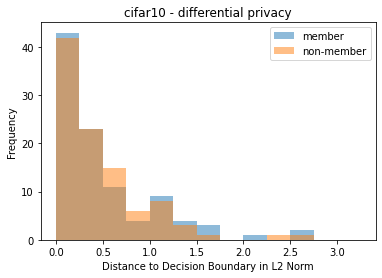

In [9]:
from matplotlib import pyplot as plt
import pandas as pd

def dist(x, x_adv):
    return np.linalg.norm(np.reshape(x_adv - x, [-1]))

dist_train = [dist(x, xa) for (x, xa) in zip(x_target_train[train_idx], x_adv_train)]
dist_test = [dist(x, xa) for (x, xa) in zip(x_target_test[test_idx], x_adv_test)]
print(pd.DataFrame(np.array(dist_train)).describe())
print(pd.DataFrame(np.array(dist_test)).describe())

bins = [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25]

plt.hist(dist_train, bins, alpha=0.5, label='member')
plt.hist(dist_test, bins, alpha=0.5, label='non-member')
plt.legend(loc='upper right')
plt.title(f'{dataset} - {algorithm}')
plt.xlabel("Distance to Decision Boundary in L2 Norm")
plt.ylabel("Frequency")
plt.show()

### 6. Measure the Advantage of An Adversary in Label-Only Membership Inference Attacks

[0.   0.   0.01 0.01 0.02 0.02 0.03 0.03 0.04 0.04 0.05 0.05 0.08 0.08
 0.11 0.11 0.13 0.13 0.14 0.14 0.16 0.16 0.17 0.17 0.2  0.2  0.25 0.25
 0.27 0.27 0.28 0.28 0.31 0.31 0.35 0.35 0.37 0.37 0.39 0.39 0.41 0.41
 0.43 0.43 0.45 0.45 0.47 0.47 0.49 0.49 0.5  0.5  0.51 0.51 0.53 0.53
 0.55 0.55 0.6  0.6  0.64 0.64 0.65 0.65 0.68 0.68 0.69 0.69 0.7  0.7
 0.71 0.71 0.72 0.72 0.75 0.75 0.78 0.78 0.79 0.79 0.8  0.8  0.83 0.83
 0.84 0.84 0.85 0.85 0.86 0.86 0.87 0.87 0.89 0.89 0.9  0.9  0.92 0.92
 0.93 0.93 0.94 0.94 0.98 0.98 1.  ]
[0.   0.01 0.01 0.02 0.02 0.03 0.03 0.06 0.06 0.07 0.07 0.1  0.1  0.14
 0.14 0.17 0.17 0.18 0.18 0.19 0.19 0.22 0.22 0.23 0.23 0.24 0.24 0.26
 0.26 0.3  0.3  0.31 0.31 0.33 0.33 0.36 0.36 0.38 0.38 0.39 0.39 0.4
 0.4  0.44 0.44 0.45 0.45 0.48 0.48 0.51 0.51 0.54 0.54 0.55 0.55 0.56
 0.56 0.57 0.57 0.59 0.59 0.62 0.62 0.64 0.64 0.66 0.66 0.67 0.67 0.68
 0.68 0.71 0.71 0.74 0.74 0.76 0.76 0.77 0.77 0.78 0.78 0.82 0.82 0.83
 0.83 0.84 0.84 0.86 0.86 0.88 0.88 0.89 0

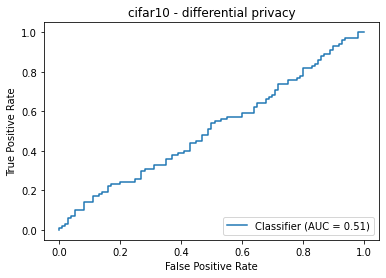

In [10]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, thresholds = roc_curve(
    np.concatenate((np.ones(len(dist_train)), np.zeros(len(dist_test)))),
    dist_train + dist_test
)
print(fpr)
print(tpr)
print(thresholds)

RocCurveDisplay.from_predictions(
    np.concatenate((np.ones(len(dist_train)), np.zeros(len(dist_test)))),
    dist_train + dist_test
)
plt.title(f'{dataset} - {algorithm}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### 7. Measure the Statistical Relationship between Distance to Decision Boundary and Confidence Scores

In [8]:
from scipy.stats.stats import pearsonr
import scipy

confidence_train = [np.amax(scipy.special.softmax(p)) for p in art_classifier.predict(x_target_train[train_idx])]
confidence_test = [np.amax(scipy.special.softmax(p)) for p in art_classifier.predict(x_target_test[test_idx])]

corr, pvalue = pearsonr(confidence_train, dist_train)
print("train correlation ", corr, pvalue)
corr, pvalue = pearsonr(confidence_test, dist_test)
print("test correlation ", corr, pvalue)

train correlation  0.8175262560081672 3.191248493217951e-25
test correlation  0.8282515612209613 2.1607252813305053e-26
